In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Thesis/saved_models/EfficientNet_best_model_9542.h5")


In [ ]:
def preprocess_image(img, target_size=(224, 224)):
    # Resize the image
    img = cv2.resize(img, target_size)
    # Convert the image from BGR (OpenCV format) to RGB (common format)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Normalize the image to [0, 1] range
    # img = img / 255.0
    # Expand dimensions to match the shape (1, height, width, channels)
    img = np.expand_dims(img, axis=0)
    return img


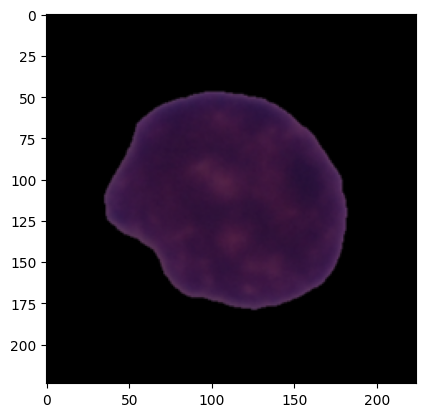

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
path = '/content/C_NMC_2019_dataset/test/hem/UID_H10_108_3_hem.PNG'
img = cv2.imread(path)
img = preprocess_image(img)

plt.imshow(img[0])
plt.show()

In [ ]:
print("ALL")
model.predict(img)

ALL
1/1 [==============================] - 0s 30ms/step


array([[9.9999964e-01, 3.9700942e-07]], dtype=float32)

In [ ]:
print("hem")
model.predict(img)

hem
1/1 [==============================] - 0s 49ms/step


array([[1.4838864e-05, 9.9998522e-01]], dtype=float32)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import output
from tensorflow.keras import layers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Thesis/C_NMC_2019_dataset.zip'
output.clear()

In [ ]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
train_dir = '/content/C_NMC_2019_dataset/training'
validation_dir = '/content/C_NMC_2019_dataset/validation'
test_dir = '/content/C_NMC_2019_dataset/test'


# using data generator to load data in batches
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()


train_generator = train_datagen.flow_from_directory(directory=train_dir, target_size=(224, 224), color_mode="rgb",
                                                    batch_size=32, class_mode="categorical", shuffle=True, seed=42)
validation_generator = validation_datagen.flow_from_directory(directory=validation_dir, target_size=(224, 224), color_mode="rgb",
                                                              batch_size=32, class_mode="categorical", shuffle=True, seed=42)
test_generator = test_datagen.flow_from_directory(directory=test_dir, target_size=(224, 224), color_mode="rgb",
                                                  batch_size=32, class_mode="categorical", shuffle=True, seed=42)

Found 37760 images belonging to 2 classes.
Found 4720 images belonging to 2 classes.
Found 4720 images belonging to 2 classes.


lr 0.0001
256 neurons
-> val acc = 0.9588

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/EfficientNet_best_model.h5')
model.summary()

In [ ]:
def model_builder(hp):

  base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

  # Freeze layers in the base model
  # base_model.trainable = True
  # fine_tune_at = len(base_model.layers)
  # for layer in base_model.layers[:fine_tune_at]:
  #     layer.trainable = False

  hp_layer_1 = hp.Int('layer_1', min_value=64, max_value=256, step=64)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(units=hp_layer_1, activation='relu'),
      tf.keras.layers.Dense(2, activation='softmax')  # 2 classes, so final layer with softmax activation
  ])



  model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy', metrics=['accuracy'])

  return model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='dir',
                     project_name='x')

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)

checkpoint_filepath = 'best_model.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      mode='max',
                                                      verbose=1)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

tuner.search(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30,
                    callbacks=[reduce_lr, model_checkpoint])

Trial 18 Complete [00h 12m 05s]
val_accuracy: 0.7495748400688171

Best val_accuracy So Far: 0.7495748400688171
Total elapsed time: 01h 36m 21s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

checkpoint_filepath = 'best_model.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      mode='max',
                                                      verbose=1)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30,
                    callbacks=[reduce_lr, model_checkpoint])

Epoch 1/30
1180/1180 [==============================] - ETA: 0s - loss: 0.3322 - accuracy: 0.8533
Epoch 1: val_accuracy improved from -inf to 0.51871, saving model to best_model.h5
1180/1180 [==============================] - 145s 99ms/step - loss: 0.3322 - accuracy: 0.8533 - val_loss: 2.3547 - val_accuracy: 0.5187 - lr: 1.0000e-04
Epoch 2/30
1180/1180 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9172
Epoch 2: val_accuracy improved from 0.51871 to 0.74426, saving model to best_model.h5
1180/1180 [==============================] - 114s 97ms/step - loss: 0.2042 - accuracy: 0.9172 - val_loss: 0.5906 - val_accuracy: 0.7443 - lr: 1.0000e-04
Epoch 3/30
1180/1180 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9414
Epoch 3: val_accuracy did not improve from 0.74426
1180/1180 [==============================] - 114s 96ms/step - loss: 0.1441 - accuracy: 0.9414 - val_loss: 71.7899 - val_accuracy: 0.4018 - lr: 1.0000e-04
Epoch 4/30
1180/1180 [====

In [ ]:
print(model.evaluate(validation_generator))
print(model.evaluate(test_generator))

148/148 [==============================] - 12s 84ms/step - loss: 0.1692 - accuracy: 0.9583
[0.169208362698555, 0.9582627415657043]
148/148 [==============================] - 13s 85ms/step - loss: 0.2110 - accuracy: 0.9475
[0.21103398501873016, 0.9474576115608215]


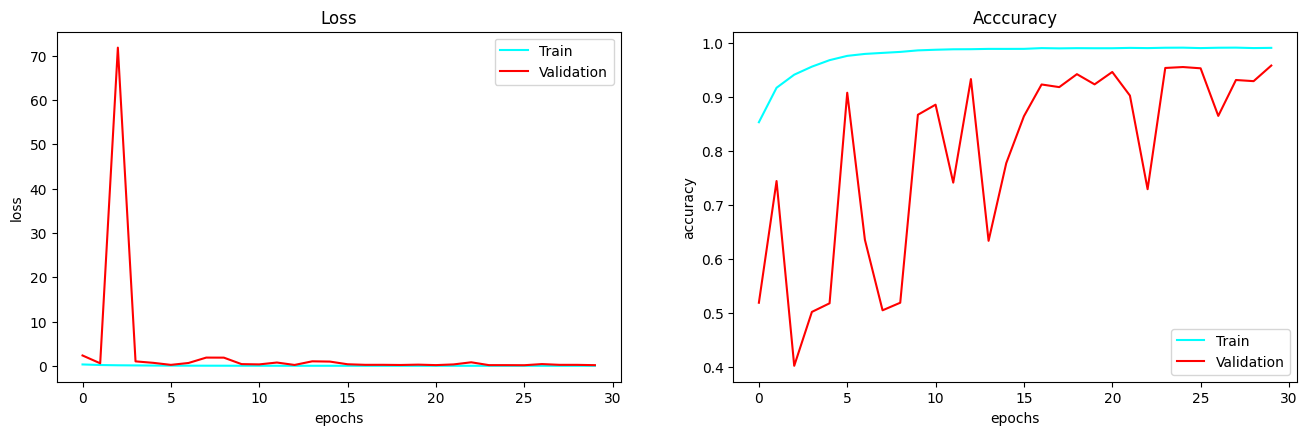

In [ ]:

plt.figure(figsize=(16,10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], color='cyan')
plt.plot(history.history['val_loss'], color='red')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')


plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], color='cyan')
plt.plot(history.history['val_accuracy'], color='red')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Acccuracy')
plt.legend(['Train', 'Validation'], loc='lower right')


plt.subplots_adjust(wspace=0.2)




In [ ]:
print(history.history)

{'loss': [0.33221447467803955, 0.20421102643013, 0.14408203959465027, 0.11212185025215149, 0.08283660560846329, 0.06334184855222702, 0.053839538246393204, 0.04901836812496185, 0.04590984433889389, 0.0375591441988945, 0.03430993854999542, 0.03327023610472679, 0.0304191242903471, 0.030679689720273018, 0.029725851491093636, 0.02889735996723175, 0.026843510568141937, 0.027684399858117104, 0.02692634053528309, 0.027216384187340736, 0.02695564366877079, 0.02505916729569435, 0.026750216260552406, 0.024949954822659492, 0.025265486910939217, 0.025868341326713562, 0.02474461868405342, 0.023698553442955017, 0.026418378576636314, 0.024781517684459686], 'accuracy': [0.8532838821411133, 0.9171609878540039, 0.9413930177688599, 0.9563029408454895, 0.9683262705802917, 0.9762712121009827, 0.9798993468284607, 0.9818061590194702, 0.9836334586143494, 0.986467182636261, 0.9876323938369751, 0.9884798526763916, 0.9886387586593628, 0.9892213940620422, 0.989194929599762, 0.9892743825912476, 0.9906514883041382, 

In [ ]:
from keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/best_model.h5')

# Print the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4378021 (16.70 MB)
Trainable params: 4335998 (16.54 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [ ]:
base_model = tf.keras.applications.EfficientNetB0()
len(base_model.layers)

21834768/21834768 [==============================] - 1s 0us/step


241

try model

In [ ]:
best_hps.values

{'freeze_at': 50,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [ ]:
def model_builder(hp):
  base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

  # Freeze layers in the base model
  base_model.trainable = True
  fine_tune_at = hp.Int('freeze_at', min_value=50, max_value=240, step=50)
  for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False

  # hp_layer_1 = hp.Int('layer_1', min_value=64, max_value=256, step=64)
  # hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(units=256, activation='relu'),
      tf.keras.layers.Dense(2, activation='softmax')  # 2 classes, so final layer with softmax activation
  ])



  model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-4),
                loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
import keras_tuner as kt

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='dir',
                     project_name='x')

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)

checkpoint_filepath = 'best_model.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      mode='max',
                                                      verbose=1)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

tuner.search(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,
                    callbacks=[reduce_lr, model_checkpoint])

Trial 4 Complete [00h 04m 02s]
val_accuracy: 0.7534013390541077

Best val_accuracy So Far: 0.8367347121238708
Total elapsed time: 00h 16m 52s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

checkpoint_filepath = 'best_model.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      mode='max',
                                                      verbose=1)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30,
                    callbacks=[reduce_lr, model_checkpoint])

Epoch 1/30
1180/1180 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.8109
Epoch 1: val_accuracy improved from -inf to 0.67474, saving model to best_model.h5
1180/1180 [==============================] - 140s 99ms/step - loss: 0.4042 - accuracy: 0.8109 - val_loss: 0.6114 - val_accuracy: 0.6747 - lr: 1.0000e-04
Epoch 2/30
1180/1180 [==============================] - ETA: 0s - loss: 0.3031 - accuracy: 0.8652
Epoch 2: val_accuracy did not improve from 0.67474
1180/1180 [==============================] - 113s 96ms/step - loss: 0.3031 - accuracy: 0.8652 - val_loss: 0.8358 - val_accuracy: 0.5081 - lr: 1.0000e-04
Epoch 3/30
1180/1180 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.8885
Epoch 3: val_accuracy did not improve from 0.67474
1180/1180 [==============================] - 114s 97ms/step - loss: 0.2582 - accuracy: 0.8885 - val_loss: 0.7832 - val_accuracy: 0.5244 - lr: 1.0000e-04
Epoch 4/30
1180/1180 [==============================] - ETA: 0

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet', drop_connect_rate=0.4)

# Freeze layers in the base model
base_model.trainable = True
fine_tune_at = 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False



model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Dense(units=640, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    # tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dense(2, activation='softmax')  # 2 classes, so final layer with softmax activation
])



model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 4052133 (15.46 MB)
Trainable params: 3962610 (15.12 MB)
Non-trainable params: 89523 (349.70 KB)
_________________________________________________________________


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

checkpoint_filepath = 'EfficientNet_best_model.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      mode='max',
                                                      verbose=1)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15,
                    callbacks=[reduce_lr, model_checkpoint])

Epoch 1/15
1180/1180 [==============================] - ETA: 0s - loss: 0.3995 - accuracy: 0.8161
Epoch 1: val_accuracy improved from -inf to 0.88818, saving model to EfficientNet_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1180/1180 [==============================] - 231s 176ms/step - loss: 0.3995 - accuracy: 0.8161 - val_loss: 0.2727 - val_accuracy: 0.8882 - lr: 1.0000e-04
Epoch 2/15
1180/1180 [==============================] - ETA: 0s - loss: 0.2825 - accuracy: 0.8812
Epoch 2: val_accuracy improved from 0.88818 to 0.91305, saving model to EfficientNet_best_model.h5
1180/1180 [==============================] - 212s 180ms/step - loss: 0.2825 - accuracy: 0.8812 - val_loss: 0.2135 - val_accuracy: 0.9131 - lr: 1.0000e-04
Epoch 3/15
1180/1180 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9056
Epoch 3: val_accuracy improved from 0.91305 to 0.92857, saving model to EfficientNet_best_model.h5
1180/1180 [==============================] - 207s 175ms/step - loss: 0.2305 - accuracy: 0.9056 - val_loss: 0.1807 - val_accuracy: 0.9286 - lr: 1.0000e-04
Epoch 4/15
1180/1180 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9241
Epoch 4: val_accuracy improved from 0.92857 to

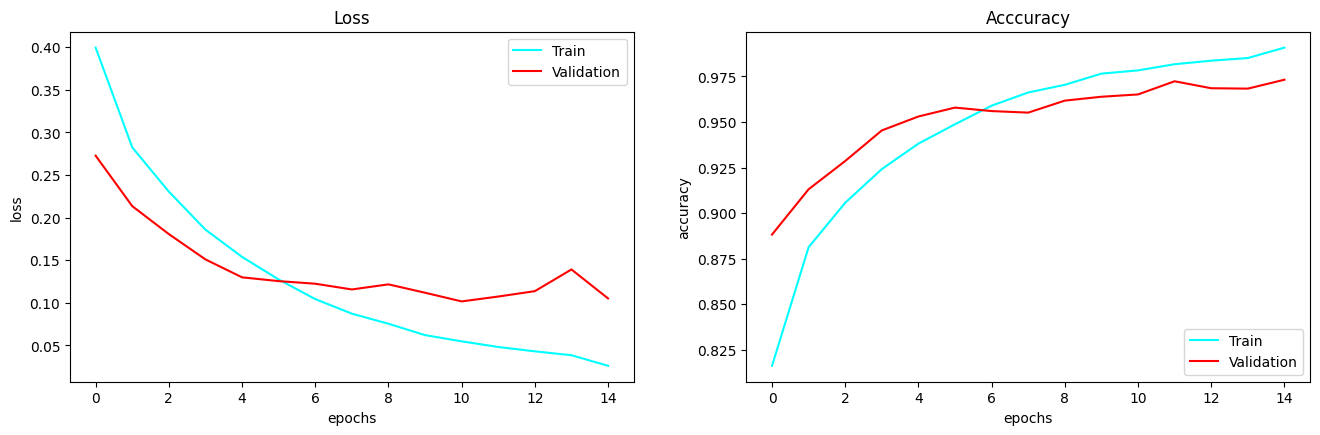

In [ ]:

plt.figure(figsize=(16,10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], color='cyan')
plt.plot(history.history['val_loss'], color='red')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')


plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], color='cyan')
plt.plot(history.history['val_accuracy'], color='red')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Acccuracy')
plt.legend(['Train', 'Validation'], loc='lower right')


plt.subplots_adjust(wspace=0.2)




In [ ]:
from google.colab import files

files.download('EfficientNet_best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/EfficientNet_best_model.h5')

In [ ]:
model.evaluate(validation_generator)

148/148 [==============================] - 350s 2s/step - loss: 0.1053 - accuracy: 0.9731


[0.10530483722686768, 0.9730932116508484]

In [ ]:
model.evaluate(test_generator)

148/148 [==============================] - 357s 2s/step - loss: 0.1744 - accuracy: 0.9542


[0.17442171275615692, 0.9542372822761536]